# Messiaen: La liturgie de Cristal

![](assets/messiaen-liturgie.jpg)

## Piano and Cello ostinato

This is the first movement in Messiaen's *Quatour pour la fin dur temps*. It is structured around a main voice in the clarinet, supported by **two isorhythmic patterns in the cello and piano**. The violin voice is composed with more freely repeating patterns in *oisseau* style. Here we will explore the two more strict isorhythmic ostinati.  

In [1]:
from maelzel.core import *
from itertools import cycle
from pitchtools import *

### Configure the environment

In [2]:
cfg = CoreConfig(active=True)
cfg['play.verbose'] = False
cfg['play.pitchInterpolation'] = 'cos'
cfg['htmlTheme'] = 'light'  # match the jupyter theme
cfg['fixStringNotenames'] = True

### Score Structure

The score does not have any tempo changes, just a slow 3/4. Messiaen writes q = ca. 54, but it is often played somewhat slower

In [3]:
scorestruct = ScoreStruct(timesig=(3, 4), tempo=50)
setScoreStruct(scorestruct)

## Talea / Color

The two *ostinati* (piano and cello) are defined by a seq. of pitches/chords and a sequence of durations, of different size. When combining both, these sequences fall out of phase, resulting in multiple rhythmical variations of the pitch structure. At the third piano cycle Messiaen skipped one color in the right hand, resuling in the hands themselves falling out of phase. For the sake of simplicity we leave this aspect out of the current analysis 

The cello durations are defined based on two cells, **A** and **B**. The *talea* (duration sequence) consists of **A** + **B** + **B**<sub>reversed</sub>

In [4]:
lowerChords = [
    "F3 G3 Bb3 C4",
    "F3 G3 Bb3 C4",
    "F3 Ab3 Bb3 Db4",
    "F3 Ab3 Bb3 Db4",
    
    "F3 G3 Bb3 D4",
    "F3 G3 Bb3 D4",
    "F3 A3 C4 D4",
    "F3 A3 C4 D4",
    
    "F3 Bb3 Db4",
    "F3 B3 D4",
    "F3 C4 Eb4",
    "F3 C#4 E4",
    
    "Ab3 Eb4 Gb4",
    "Ab3 Eb4 F4",
    "Gb3 Db4 Ab4",
    "Gb3 Db4 Bb4",
    
    "A3 C4 D4 F#4 Bb4",
    "Bb3 C#4 E4 G#4",
    "C4 D4 F4",
    "C#4 E4 F#4",
    
    "F4 G#4 Bb4",
    "F#4 A4 B4",
    "F4 Bb4",
    "E4 Ab4",
    
    "D4 G4",
    "C#4 F4",
    "B3 E4",
    "Ab3 C#4",
    "Gb3 3B",
]

upperChords = [
    "Eb4 B4 E5",
    "Eb4 A4 D5",
    "Eb4 A4 D5",
    "Eb4 G4 C5",
    "F#4 B4 C5",
    "E4 A4 C5",
    "G4 C#5 F#5",
    "G4 B4 E5",
    "Gb4 E5",
    "G4 E5 G5",
    "Ab4 G5",
    "A4 G5 B5",
    "Bb4 Eb5 Gb5 Cb6",
    "Bb4 Db5 F5 Bb5",
    "Eb5 Ab5 Cb6 Eb6",
    "D5 F5 Bb5 D6",
    "Db5 Gb5 Bb5 Db6",
    "C5 D5 G#5 C6",
    "A4 C#5 E5 A5",
    "Bb4 D5 F5",
    "D5 F#5 A5",
    "D#5 E#5 G#5",
    "D5 E5 G5",
    "C#5 D5",
    "B4 C#5 E5",
    "Bb4 B4 F5",
    "Ab4 Bb4",
    "F4 G4",
    "Eb4 F4",
]

pianoDurs = [1, 1, 1, 0.5, 
             0.75, 0.5, 0.5, 0.5, 
             0.5, 0.75, 0.75, 0.75, 
             0.25, 0.5, 0.75, 1, 
             2]

celloPitches = ["C4", "E4", "D4", "F#4", "Bb3"]
celloA = [2, 1.5, 2]  
celloB = [2, 0.5, 0.5, 1.5, 0.5, 0.5]
celloDurs = celloA + celloB + celloB[::-1]

In [5]:
def makeIsorhythm(cls, color, talea, maxdur):
    totaldur = 0
    for n, dur in zip(cycle(color), cycle(talea)):
        totaldur += dur
        if totaldur > maxdur:
            break
        yield cls(n, dur=dur)

For each voice we create an isorhythm. The duration of the glissandi in the cello seem to be related to readability, starting always in a quarter note if they are longer than an 1/8 note.  

In [6]:
# Total duration of the score. This sets how much music we are going to generate

maxdur = 80

# Piano
leftchords = list(makeIsorhythm(Chord, lowerChords, pianoDurs, maxdur))
rightchords = list(makeIsorhythm(Chord, upperChords, pianoDurs, maxdur))

# Cello
cellonotes0 = makeIsorhythm(Note, celloPitches, celloDurs, maxdur-4)
cellonotes0 = Chain(cellonotes0).timeShift(5.5).setPlay(transpose=24)
cellonotes0.stack()

# Add cello glissandi between F# and Bb
cellonotes = []
for n in cellonotes0:
    if n.pitch == n2m("4F#"):
        if n.dur <= 0.75:
            cellonotes.append(n.clone(gliss=True))
        else:
            glissdur = 1 if n.end % 1 == 0 else 1.5 if n.dur > 1.5 else 0.5
            n0 = n.clone(dur=n.dur-glissdur, tied=True)
            n1 = n.clone(dur=glissdur, offset=n0.end, gliss=True)
            cellonotes.extend([n0, n1])
    else:
        cellonotes.append(n)
        
# Display the cello notes as artificial 4th harmonics
for note in cellonotes:
    note.addSymbol(symbols.Harmonic('artificial', 5))


Score(3 voices)
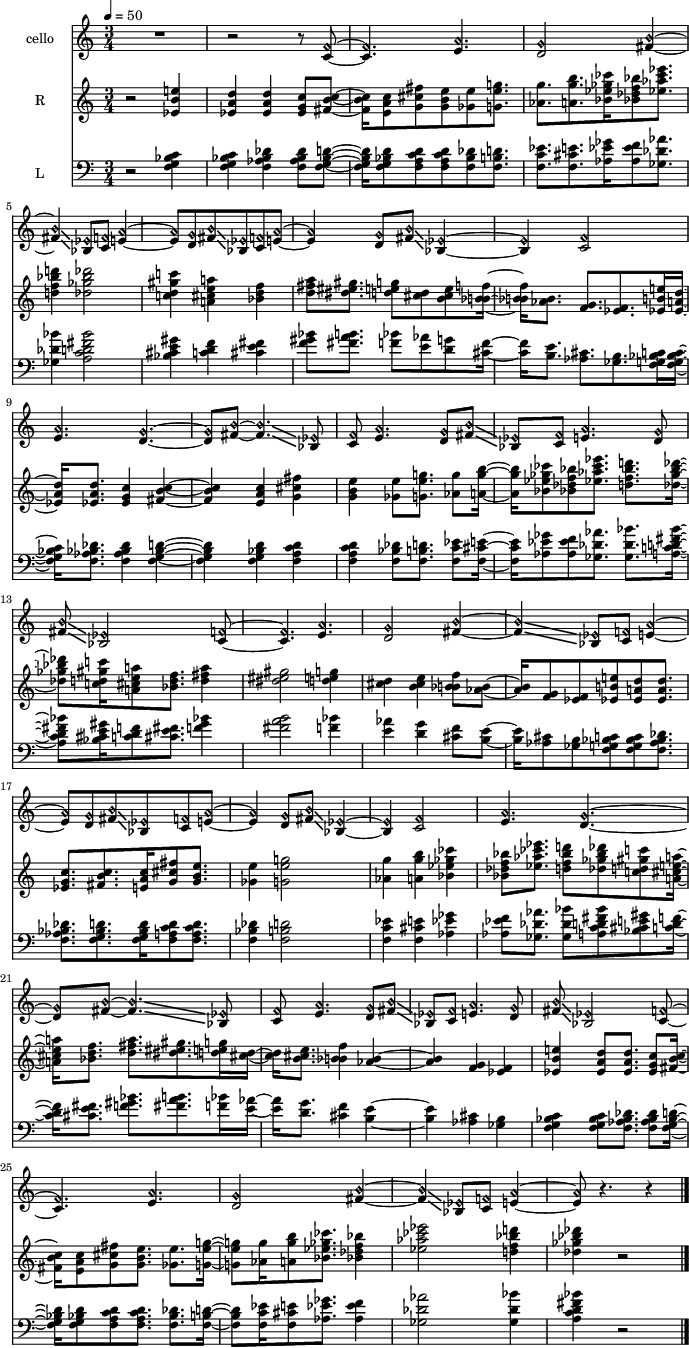

In [7]:
# Create voices, add offset
lefthand  = Voice(leftchords, 'L', clef='bass').timeShift(2)
righthand = Voice(rightchords, 'R', clef='treble').timeShift(2)
cello = Voice(cellonotes, name='cello', clef='treble')

# Score, from high to low
sco = Score([cello, righthand, lefthand])
# cfg['show.respellPitches'] = False
sco

In [8]:
# Make the highest note of the piano somewhat louder than the rest
for ch in righthand:
    ch[-1].amp = 0.4
    for n in ch[:-1]:
        n.amp = 0.15
        
for ch in lefthand:
    ch.amp = 0.15

In [9]:
# Define instrument presets 

# cello harmonics
defPreset('flageolet-vibr', r'''
    |imaxvibfreq=5.6, itransp=24, ivibdepth=0.35|
    kt timeinsts
    kvibfreq  = bpf:k(kt, 0, 0, 0.4, imaxvibfreq)
    kvibsteps = bpf:k(kt, 0, 0, 1.1, ivibdepth)
    kvibr0 = oscili:k(1, kvibfreq) * kvibsteps - kvibsteps * 0.8
    kvibr = lag:k(1 - changed(kpitch), 0.2) * kvibr0
    kpitch2 = kpitch + kvibr + itransp
    kpitch2 = lag:k(kpitch2, 0.8)
    kfreq = mtof:k(kpitch2)
    aout1 = oscili:a(kamp, a(kfreq))
    aout1 += oscili:a(kamp*0.08, kfreq*2)
    aout1 += oscili:a(kamp*0.01, kfreq*3)
    ''', 
)

# Use a soundfont as instrument preset for the piano part
# sf2 from http://freepats.zenvoid.org/Piano/YDP-GrandPiano/grand-piano-YDP-20160804.tar.bz2
defPresetSoundfont('piano', '/home/em/Lib/snd/sf2/Piano--grand-piano-YDP.sf2')
;

''

OfflineRenderer(sr=44100)
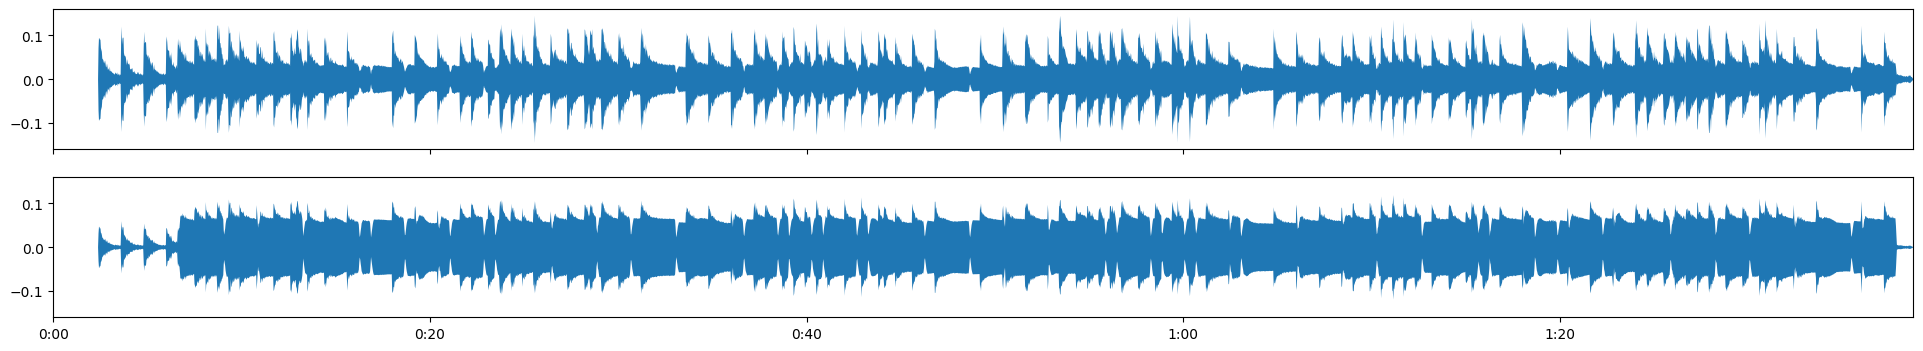

In [10]:
# Set playback options

maingain = 0.8
lefthand.setPlay(instr='piano', gain=maingain, position=0.25, fade=(0.01, 0.2), sustain=0.2)
righthand.setPlay(instr='piano', gain=maingain, position=0.25, fade=(0.01, 0.2), sustain=0.2)
cello.setPlay(instr='flageolet-vibr', gain=maingain*0.15, fade=(0.25, 0.1), position=0.75)
sco.rec()


## Global Effects

Create a reverb, scheduled at a higher priority

OfflineRenderer(sr=44100)
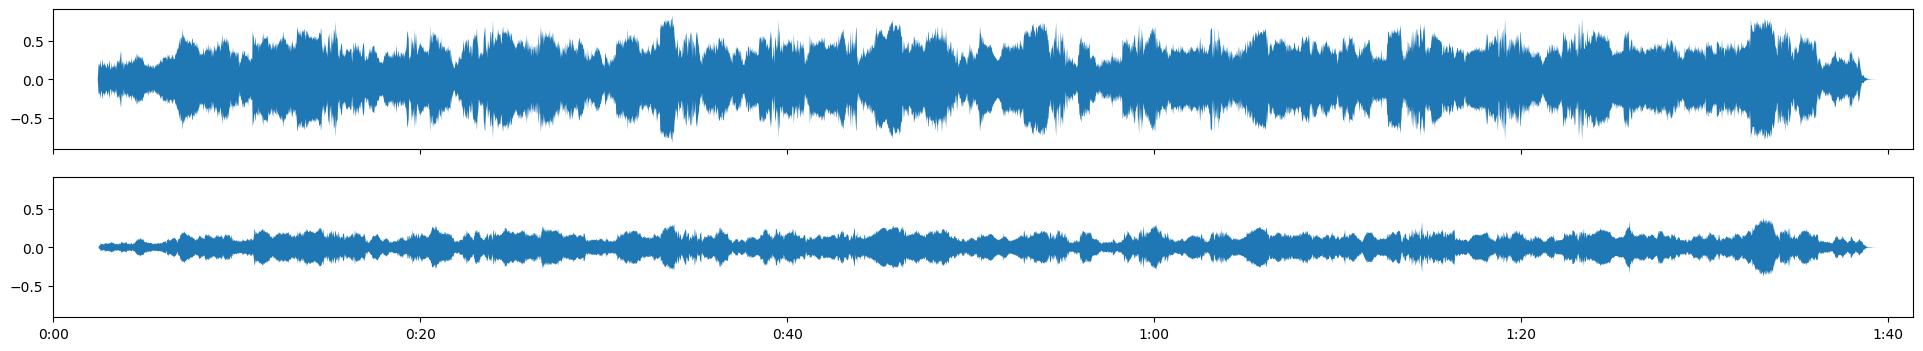

In [12]:
s = playSession()
s.defInstr('reverb', r'''
  |kfeedback=0.6|
  amon1, amon2 monitor
  a1, a2 reverbsc amon1, amon2, kfeedback, 12000, sr, 0.3
  outch 1, a1-amon1, 2, a2-amon2
''')

endtime = sco.durSecs()
with render("tmp/messiaen.wav") as r:
    s.sched('reverb', dur=float(endtime)+3, priority=2, kfeedback=0.6)
    sco.play()
r